In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import soundfile as sf
import random
import pyrubberband as pyrb  # bibliothèque spéciale pour ça


In [3]:
# appliquer data augmentation sur tout le data  
def add_noise(data, noise_level=0.005):
    noise = np.random.randn(len(data))
    return data + noise_level * noise

def change_pitch(data, sr, n_steps):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)


def change_speed(data, sr, speed_factor):
    new_sr = int(sr * speed_factor)
    y_stretched = librosa.resample(y=data, orig_sr=sr, target_sr=new_sr)
    return librosa.resample(y_stretched, orig_sr=new_sr, target_sr=sr)



def change_volume(data, gain=1.2):
    return data * gain

def augment_file(file_path, output_folder, base_name):
    y, sr = librosa.load(file_path, duration=5.0)

    augmentations = {
        "noise": add_noise(y),
        "pitch_up": change_pitch(y, sr, 2),
        "pitch_down": change_pitch(y, sr, -2),
        "speed_up": change_speed(y, sr, 1.2),
        "speed_down": change_speed(y, sr, 0.8),
        "volume_up": change_volume(y, 1.5),
        "volume_down": change_volume(y, 0.5)
    }

    for aug_type, y_aug in augmentations.items():
        output_path = os.path.join(output_folder, f"{base_name}_{aug_type}.wav")
        sf.write(output_path, y_aug, sr)

def process_dataset(input_folder, output_folder):
    for class_name in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_name)
        out_class_path = os.path.join(output_folder, class_name)
        os.makedirs(out_class_path, exist_ok=True)

        for i, file in enumerate(os.listdir(class_path)):
            if file.endswith(".wav") or file.endswith(".mp3"):
                input_file = os.path.join(class_path, file)
                base_name = os.path.splitext(file)[0]
                # Copie originale
                sf.write(os.path.join(out_class_path, f"{base_name}_original.wav"), *librosa.load(input_file, duration=5.0))
                # Augmentations
                augment_file(input_file, out_class_path, base_name)

if __name__ == "__main__":
    input_path = "audios" # ton dossier original
    output_path =  "audios"  # dossier de sortie
    process_dataset(input_path, output_path)
    print("✅ Augmentation terminée !")


c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\ASUS\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


✅ Augmentation terminée !


In [4]:
# Classes de pannes
classes = [ "normale" ,"Fuel injector","water_pump",
    "knocking",
    "exhaust_leak",
    "belt_squeal",
    "alternator_pulley"]
data = []  #contient le mfcc extraite 
labels = [] #contient le classe 

def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, duration=5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc

In [6]:
# Charger les fichiers
base_path = 'audios'
for i, class_name in enumerate(classes):
    class_path = os.path.join(base_path, class_name)
    for file in os.listdir(class_path):
        try:
            #normalisation de la teille de mfcc 
            mfcc = extract_mfcc(os.path.join(class_path, file))
            if mfcc.shape[1] < 216:  # Uniformiser la taille
                mfcc = np.pad(mfcc, ((0, 0), (0, 216 - mfcc.shape[1])))
            mfcc = mfcc[:, :216]
            data.append(mfcc)
            labels.append(i)
        except:
            continue


In [7]:

# Conversion pour CNN
# Convertit la liste Python data (qui contient les tableaux MFCC de chaque fichier audio) en un tableau NumPy multidimensionnel.
X = np.array(data)
X = X[..., np.newaxis]  # shape: (samples, 40, 216, 1)
y = to_categorical(labels, num_classes=7)


In [8]:
# --- Fixer les seeds ---
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
#modéle CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 216, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# entrainement de modéle 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6185 - loss: 8.4909 - val_accuracy: 0.9724 - val_loss: 0.0869
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9899 - loss: 0.0481 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 1.0000 - loss: 6.5287e-04 - val_accuracy: 1.0000 - val_loss: 6.5897e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 1.0000 - loss: 3.4050e-04 - val_accuracy: 1.0000 - val_loss: 4.9434e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 1.0000 - loss: 2.3648e-04 - val_accuracy: 1.0000 - val_loss: 3.8897e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 1.7915e-0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
=== Rapport de classification ===
                   precision    recall  f1-score   support

          normale       1.00      1.00      1.00        18
    Fuel injector       1.00      1.00      1.00        16
       water_pump       1.00      1.00      1.00       146
         knocking       1.00      1.00      1.00        19
     exhaust_leak       1.00      1.00      1.00        15
      belt_squeal       1.00      1.00      1.00        19
alternator_pulley       1.00      1.00      1.00        21

         accuracy                           1.00       254
        macro avg       1.00      1.00      1.00       254
     weighted avg       1.00      1.00      1.00       254



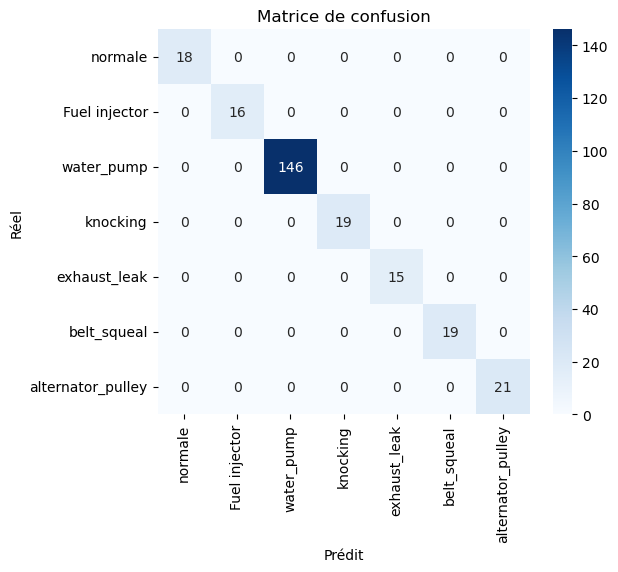

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 🔄 Prédictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📊 Rapport de classification
print("=== Rapport de classification ===")
print(classification_report(y_true, y_pred, target_names=classes))

# 📉 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


In [11]:
from tensorflow import keras
model.save("mon_modele_CNN1.keras")